In [1]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

2024-02-09 13:40:37.294481: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 13:40:37.448937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 13:40:37.448974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 13:40:37.476218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 13:40:37.537988: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 13:40:37.538653: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = None #Std for noisy networks (put None if you don't want a noisy network)
random_training = True #Training on sequence of random length chosen uniformely in [|1,12|]
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'pre'

In [4]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Training

In [5]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [6]:
agent.train(env,3000,batch_size=batch_size,nb_fit=5,verbose=1)
agent.save('UniversalRNN-'+str(condition)+'-'+str(rnn_noise))

0 0.529
1 0.5155000000000001
2 0.5135000000000001
3 0.5095000000000001
4 0.5089
5 0.5143333333333334
6 0.5228571428571429
7 0.530125
8 0.5359444444444443
9 0.53835
10 0.54145
11 0.5471
12 0.5539000000000001
13 0.56175
14 0.5694
15 0.5713
16 0.5729
17 0.5723499999999999
18 0.5747
19 0.57775
20 0.5807
21 0.58255
22 0.5831000000000001
23 0.5835000000000001
24 0.5831999999999999
25 0.5837999999999999
26 0.58395
27 0.5842999999999999
28 0.5822499999999999
29 0.5811999999999999
30 0.58095
31 0.5831999999999999
32 0.5816
33 0.5826
34 0.581
35 0.5849500000000001
36 0.58485
37 0.5880000000000001
38 0.5889499999999999
39 0.5911500000000001
40 0.5909500000000001
41 0.5904999999999999
42 0.59265
43 0.5927999999999999
44 0.59425
45 0.5951500000000001
46 0.59595
47 0.5951500000000001
48 0.5957
49 0.5949000000000001
50 0.5967
51 0.59765
52 0.597
53 0.5973499999999999
54 0.6006500000000001
55 0.6005
56 0.6009500000000001
57 0.6019
58 0.60315
59 0.60625
60 0.6079000000000001
61 0.6089
62 0.6112
63 0.61

In [7]:
agent.save('UniversalRNN-'+str(condition)+'-'+str(rnn_noise))

SAVING ['nn', 'out_nn']


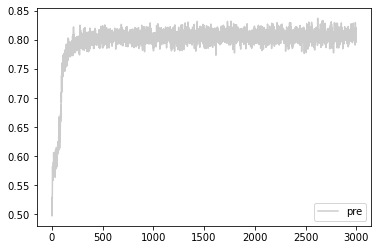

In [8]:
#Plot accuracies
plt.plot(range(len(agent.scores)),agent.scores,alpha=0.4,color='grey',label=condition)
plt.legend()
plt.show()

### Plots

In [55]:
rnn_noise = None

In [56]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [57]:
agent.load('UniversalRNN-'+str(condition)+'-'+str(rnn_noise))

LOADING ['nn', 'out_nn']


In [58]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [59]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1,2] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [60]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [61]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [62]:
out = agent.nn(batch_obs).numpy()[:,:,:]
choice = agent.predict(batch_obsf).numpy()

In [63]:
batch_obsf.get('ref')

array([0.        , 4.71238898, 3.92699082, ..., 2.35619449, 1.57079633,
       1.57079633])

In [64]:
#Residue ref
#cosref = np.cos(batch_obsf.get('ref'))[:,None]
#sinref = np.sin(batch_obsf.get('ref'))[:,None]
#ref = np.concatenate([cosref,sinref],axis=1)
#ref = ref[:,None,:].repeat(out.shape[1],axis=1).reshape((-1,2))
#out = residue(out,ref)

#Residue choice
choice_batch = choice[:,None].repeat(out.shape[1],axis=1).reshape((-1,1))
out = residue(out, choice_batch)

#Residue mean angle
#mean_angle = np.mean(batch_obsf.get('obs')[:,:,:2],axis=1)[:,None,:].repeat(out.shape[1],axis=1).reshape((-1,2))
#out = residue(out,mean_angle)

score 0.06595968166545398


In [65]:
#fit pca
pca = fit_pca(out.reshape((-1,64)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,64))).reshape(out.shape[:-1]+(nb_variance,))

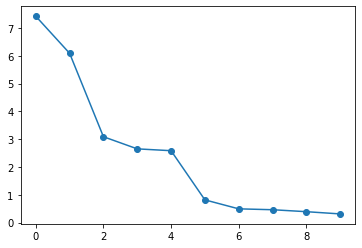

In [66]:
%matplotlib inline
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [67]:
batch_obsf.get('mean')

array([[3.14159265, 3.14159265, 3.14159265, ..., 3.14159265, 3.14159265,
        3.14159265],
       [4.71238898, 4.71238898, 4.71238898, ..., 4.71238898, 4.71238898,
        4.71238898],
       [3.92699082, 3.92699082, 3.92699082, ..., 3.92699082, 3.92699082,
        3.92699082],
       ...,
       [5.49778714, 5.49778714, 5.49778714, ..., 5.49778714, 5.49778714,
        5.49778714],
       [1.57079633, 1.57079633, 1.57079633, ..., 1.57079633, 1.57079633,
        1.57079633],
       [1.57079633, 1.57079633, 1.57079633, ..., 1.57079633, 1.57079633,
        1.57079633]])

In [68]:
plt.get_cmap('rainbow')(0),plt.get_cmap('rainbow')(1)

((0.5, 0.0, 1.0, 1.0),
 (0.49215686274509807, 0.012319659535238442, 0.9999810273487268, 1.0))

In [69]:
#Plot background function
def plot_bg(pca_batch,zorder=0):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('pca1')
    ax.set_ylabel('pca2')
    ax.set_zlabel('pca3')
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    cm = plt.get_cmap('rainbow')
    obj = batch_obsf.get('mean')[:,0]/(2*np.pi)
    #mean_angle = np.mean(batch_obsf.get('obs')[:,:,:2],axis=1)
    #obj = (np.arctan2(mean_angle[:,1],mean_angle[:,0])+np.pi)/(2*np.pi)
    #obj = batch_obsf.get('ref')/(2*np.pi)
    #obj = batch_obsf.get('color')/0.5
    obj = choice/0.5
    colors = [[cm(ref) for ref in obj] for i in range(pca_batch.shape[1])]
    unique_refs = np.unique(obj)
    for i,r in enumerate(unique_refs):
        c = cm(r)
        label = str(r)
        ax.plot([0],[0],[0],color=c,label=label,zorder=zorder)
    for i in range(pca_batch.shape[1]):
        ax.scatter(pca_batch[:,i,2],pca_batch[:,i,3],pca_batch[:,i,4],color=colors[i],alpha=0.1,marker='.',zorder=zorder)

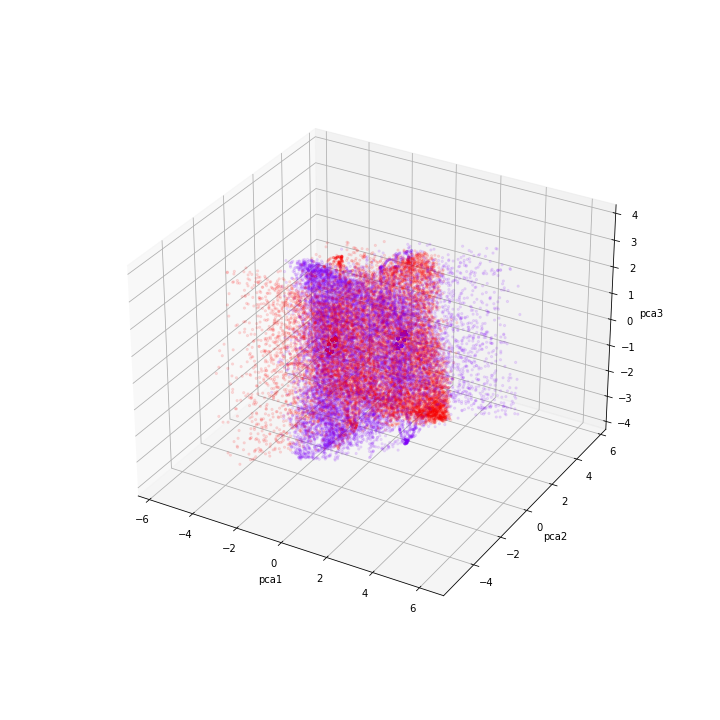

In [70]:
%matplotlib widget
from mpl_toolkits import mplot3d
plot_bg(pca_batch)
plt.show()